## Atelier : Système flou et apprentissage automatique

Dans ce TP, nous allons :
1. Construire un **système flou Mamdani** pour évaluer le **risque de panne** en fonction de la **température**, de la **vibration** et de l’**âge** d’une machine.
2. Générer un jeu de données en appliquant ce système à des valeurs aléatoires.
3. Entraîner deux modèles de **machine learning** (Régression Linéaire et Forêt Aléatoire) pour approximer le comportement du système flou.
4. Comparer leurs performances et visualiser les résultats.


### Importation des bibliothèques

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


### Fonctions d’appartenance (triangulaire et trapézoïdale)

In [2]:
def trimf(x, a, b, c):
    """Fonction d'appartenance triangulaire"""
    x = np.asarray(x)
    y = np.zeros_like(x, dtype=float)
    idx2 = (x > a) & (x <= b)
    idx3 = (x > b) & (x < c)
    if b != a:
        y[idx2] = (x[idx2] - a) / (b - a)
    if c != b:
        y[idx3] = (c - x[idx3]) / (c - b)
    return y

def trapmf(x, a, b, c, d):
    """Fonction d'appartenance trapézoïdale"""
    x = np.asarray(x)
    y = np.zeros_like(x, dtype=float)
    idx2 = (x > a) & (x <= b)
    idx3 = (x > b) & (x <= c)
    idx4 = (x > c) & (x < d)
    if b != a:
        y[idx2] = (x[idx2] - a) / (b - a)
    y[idx3] = 1.0
    if d != c:
        y[idx4] = (d - x[idx4]) / (d - c)
    return y


### Définition des ensembles flous (MFs)

In [3]:
def temp_mfs(x):
    return {
        'Basse': trapmf(x, 0, 0, 0, 40),
        'Normale': trimf(x, 30, 50, 70),
        'Élevée': trapmf(x, 60, 100, 100, 100)
    }

def vib_mfs(x):
    return {
        'Faible': trapmf(x, 0, 0, 0, 4),
        'Moyenne': trimf(x, 2, 5, 8),
        'Forte': trapmf(x, 6, 10, 10, 10)
    }

def age_mfs(x):
    return {
        'Neuf': trapmf(x, 0, 0, 0, 7),
        'Moyen': trimf(x, 5, 10, 15),
        'Ancien': trapmf(x, 12, 20, 20, 20)
    }

def risk_mfs(x):
    return {
        'Faible': trapmf(x, 0, 0, 0, 4),
        'Moyen': trimf(x, 2, 5, 8),
        'Élevé': trapmf(x, 6, 10, 10, 10)
    }


### Fonction d’inférence floue Mamdani

In [5]:
u_risk = np.linspace(0, 10, 1001)

def infer_risk(temp, vib, age):
    t = temp_mfs(np.array([temp]))
    v = vib_mfs(np.array([vib]))
    a = age_mfs(np.array([age]))

    # Degrés d'appartenance
    tB, tN, tE = t['Basse'][0], t['Normale'][0], t['Élevée'][0]
    vF, vM, vT = v['Faible'][0], v['Moyenne'][0], v['Forte'][0]
    aN, aM, aA = a['Neuf'][0], a['Moyen'][0], a['Ancien'][0]

    # Règles
    r1 = max(tE, vT)                  # R1 : risque élevé
    r2 = min(aA, vM)                  # R2 : risque moyen
    r3 = min(tB, vF, aN)              # R3 : risque faible
    r4 = min(tN, aM)                  # R4 : risque moyen

    rmfs = risk_mfs(u_risk)
    elev = np.fmin(r1, rmfs['Élevé'])
    moyen = np.fmax(np.fmin(r2, rmfs['Moyen']), np.fmin(r4, rmfs['Moyen']))
    faible = np.fmin(r3, rmfs['Faible'])
    agg = np.fmax(np.fmax(faible, moyen), elev)

    # Défuzzification (centroïde)
    if np.sum(agg) == 0:
        return 0
    return np.sum(agg * u_risk) / np.sum(agg)


### Génération de données aléatoires

In [6]:
np.random.seed(42)
N = 2000
temps = np.random.uniform(0, 100, N)
vibs = np.random.uniform(0, 10, N)
ages = np.random.uniform(0, 20, N)

risks = np.array([infer_risk(t, v, a) for t, v, a in zip(temps, vibs, ages)])

df = pd.DataFrame({'temperature': temps, 'vibration': vibs, 'age': ages, 'risk': risks})
df.head()


,temperature,vibration,age,risk
0,37.454012,2.617057,11.439918,5.000000
1,95.071431,2.469788,16.108647,7.582008
2,73.199394,9.062546,15.203219,8.610158
3,59.865848,2.495462,3.077998,0.000000
4,15.601864,2.719497,2.984989,1.702738


### Entraînement des modèles ML

In [7]:
X = df[['temperature', 'vibration', 'age']]
y = df['risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=100, random_state=7)

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)


### Évaluation des modèles

In [8]:
def scores(y_true, y_pred, name):
    print(f"Modèle {name}")
    print("MSE :", mean_squared_error(y_true, y_pred))
    print("R² :", r2_score(y_true, y_pred))
    print("-"*40)

scores(y_test, y_pred_lr, "Régression Linéaire")
scores(y_test, y_pred_rf, "Random Forest")


Modèle Régression Linéaire
MSE : 4.044530401752915
R² : 0.528998719629562
----------------------------------------
Modèle Random Forest
MSE : 0.1848700399782369
R² : 0.9784711655290944
----------------------------------------


### Visualisations

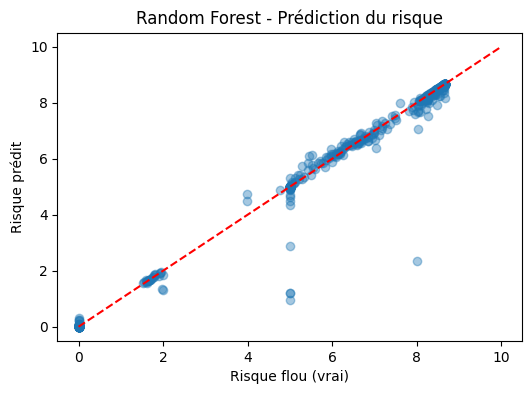

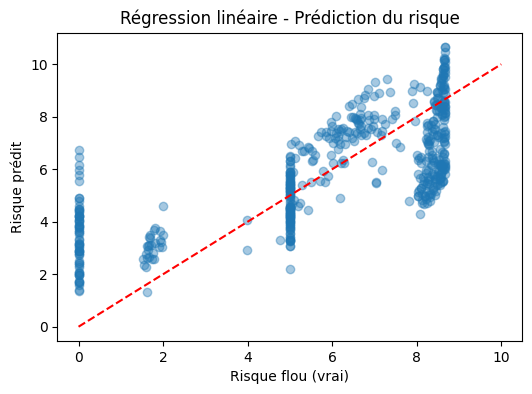

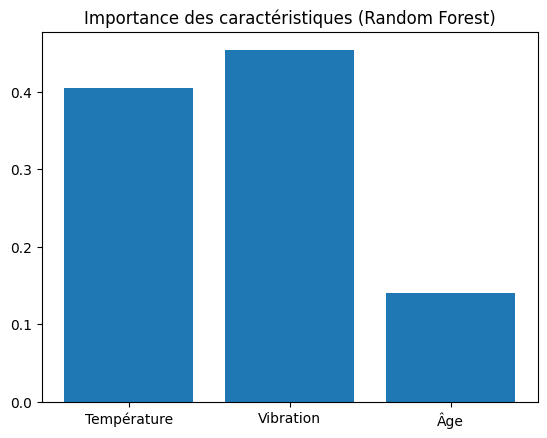

In [9]:
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_rf, alpha=0.4)
plt.plot([0,10],[0,10],'r--')
plt.xlabel("Risque flou (vrai)")
plt.ylabel("Risque prédit")
plt.title("Random Forest - Prédiction du risque")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_lr, alpha=0.4)
plt.plot([0,10],[0,10],'r--')
plt.xlabel("Risque flou (vrai)")
plt.ylabel("Risque prédit")
plt.title("Régression linéaire - Prédiction du risque")
plt.show()

plt.bar(['Température','Vibration','Âge'], rf.feature_importances_)
plt.title("Importance des caractéristiques (Random Forest)")
plt.show()


## Conclusion

- Le système flou Mamdani construit permet de modéliser le raisonnement expert.
- Les règles définissent clairement la logique du risque.
- Le modèle **Random Forest** apprend à reproduire très fidèlement la sortie du système flou (R² ≈ 0.98), contrairement à la régression linéaire (R² ≈ 0.52).
- Cette approche hybride (Flou + ML) permet de combiner **interprétabilité** et **performance**.
